In [22]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from keras import Sequential, Model
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, 
    MaxPooling2D, UpSampling2D, Rescaling, Resizing)
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from IPython.display import clear_output

from datetime import datetime
import time

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import preprocess_input

In [23]:
import random
random_seed = 5
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

In [24]:
class PlotLearning(Callback):
    """
    Callback to plot metrics during training
    """
    def __init__(self, showLR=False):
      self.showLR = showLR                 

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metric = [x for x in logs if ('val' not in x) and ('lr' not in x)]
        if self.showLR:
          metric.append('lr')
        
        f, axs = plt.subplots(1,len(metric),figsize=(10,4))
        clear_output(wait=True)
        for i,ax in enumerate(axs):
          ax.plot(range(1, epoch + 2), self.metrics[metric[i]],'o--',label=metric[i])
          try:
            ax.plot(range(1, epoch + 2), self.metrics['val_' + metric[i]], 'o--', label='val_' + metric[i])
          except:
            pass
          ax.set_xlabel('# epochs')
          ax.set_ylabel(metric[i])
          ax.legend()
          ax.grid()

        plt.tight_layout()
        plt.show()

In [25]:
def get_model_metrics(test_data, model, model_name):
    """
    Evaluates a binary classification model on test data and reports various performance metrics.
    It calculates the confusion matrix, ROC curve, and several statistical measures including accuracy, 
    sensitivity, specificity, precision, NPV (Negative Predictive Value), PLR (Positive Likelihood Ratio), 
    NLR (Negative Likelihood Ratio), and F1-score. Additionally, it identifies the best threshold for 
    classification based on the max sensitivity within a minimum required specificity.

    The function saves the confusion matrix and ROC curve plots in a local directory, and appends the 
    calculated metrics to a CSV file. This file is created if it doesn't exist, or updated if it does.

    Parameters:
    - test_data (iterable): The test dataset, typically a generator or an iterable that yields batches 
      of images and labels.
    - model (keras.Model): The trained Keras model to evaluate.
    - model_name (str): The name of the model, used for saving output files.

    No return value. The function directly prints the calculated metrics and saves the results and plots 
    to the local file system.
    """
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    results_folder = 'results'
    csv_file = f'{results_folder}/model_performance.csv'
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    predicted_probs = []
    true_labels = []
    for images, labels in test_data:
        predictions = model.predict(images, verbose=0)
        predicted_probs.extend(predictions.flatten())
        true_labels.extend([int(label) for label in labels])
        
    # ROC AUC
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)
    
    # Calculate max sensitivity where specificity is >= 1 - prevalence
    prevalence = sum(true_labels) / len(true_labels)
    
    max_sensitivity = 0
    for i in range(len(fpr)):
        specificity = 1 - fpr[i]
        if specificity >= 1 - prevalence:
            max_sensitivity = max(max_sensitivity, tpr[i])
    print(f"Max Sensitivity at Specificity >= {1 - prevalence:.2f}: {max_sensitivity:.2f}")
    
    # Confusion Matrix
    threshold_for_max_sensitivity = thresholds[np.argmax(tpr == max_sensitivity)]
    final_predicted_labels = [1 if p > threshold_for_max_sensitivity else 0 for p in predicted_probs]
    confusion_mtx = confusion_matrix(true_labels, final_predicted_labels)
    
    # Plot the confusion matrix
    f, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Purples", linecolor="gray", fmt='.1f', ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()
    
    # Classification report
    report = classification_report(true_labels, final_predicted_labels)
    print(report)
    
    # calculate additional metrics
    TP = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 1))
    TN = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 0))
    FP = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 1))
    FN = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 0))

    accuracy = accuracy_score(true_labels, final_predicted_labels)
    sensitivity = recall_score(true_labels, final_predicted_labels)  # recall
    specificity = TN / (TN + FP)
    precision = precision_score(true_labels, final_predicted_labels)  # PPV
    npv = TN / (TN + FN)
    plr = sensitivity / (1 - specificity)
    nlr = (1 - sensitivity) / specificity
    f1_pos_class = f1_score(true_labels, final_predicted_labels)

    # create a DataFrame and append to the CSV file
    df = pd.DataFrame({
        'Model Name': [model_name],
        f'Max Sensitivity at Specificity {1 - prevalence:.2f}': [max_sensitivity],
        'AUC': [roc_auc],
        'F1-Score Positive Class': [f1_pos_class],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'PPV': [precision],
        'NPV': [npv],
        'PLR': [plr],
        'NLR': [nlr]
    }).round(2) 
    
    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)

    print(df)
    
    # Plotting and saving ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [26]:
METRICS = [
       keras.metrics.AUC(name='auc'),
]

# Define a function to build a model transforming first layer to take grayscale

In [27]:
def build_model(base_model, transfer_learning):
    """
    Constructs a neural network model based on a specified base model and a transfer learning option.

    This function initializes a new model by setting the base model's trainable parameter according to 
    the transfer_learning flag ('Y' for non-trainable and 'N' for trainable). It modifies the input 
    layer to accommodate grayscale images and expands the single channel to three channels using a 
    Conv2D layer. The function then applies the base model and adds additional top layers for classification. 
    It returns the newly created model, which is suitable for binary classification tasks.

    Parameters:
    - base_model (keras.Model): The pre-existing model to use as the base.
    - transfer_learning (str): A flag ('Y' or 'N') indicating whether to freeze (non-trainable) or unfreeze 
      (trainable) the layers of the base model for transfer learning.

    Returns:
    - keras.Model: The constructed model ready for training.
    """
    # Set the base_model to be trainable or non-trainable
    if transfer_learning == 'Y':
        base_model.trainable = False
    elif transfer_learning == 'N':
        base_model.trainable = True
    print('base_model.trainable set to', base_model.trainable)

    # Define a new input layer for grayscale images
    input_layer = Input(shape=(224, 224, 1), name='grayscale_input')

    # Add a Conv2D layer to expand the single channel to three channels
    x = Conv2D(3, (3, 3), padding='same')(input_layer)

    # Add the rest of the model
    x = base_model(x)

    # Add own top layers for classification
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create the new model
    model = Model(inputs=input_layer, outputs=outputs)

    return model

# Image Augmentation

In [28]:
def augment_image(image, label):
    # Randomly apply different augmentations to the image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)  # Adjust brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Adjust contrast
    return image, label

# ResNet18-TL-no-CW

In [29]:
!pip install image-classifiers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00


In [30]:
from classification_models.tfkeras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')

## Train on anterior placental images only

In [10]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/a-pre-11-mask/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/a-pre-11-mask/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/a-pre-11-mask/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 384 files belonging to 2 classes.
Found 78 files belonging to 2 classes.
Found 87 files belonging to 2 classes.


In [11]:
def preprocess_data_resnet18(image, label):
    image = preprocess_input(image)
    return image, label

prep_train_data = train_data.map(preprocess_data_resnet18)
prep_val_data = val_data.map(preprocess_data_resnet18)
prep_test_data = test_data.map(preprocess_data_resnet18)

train_data_augmented = prep_train_data.map(augment_image)

In [14]:
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y')

# Compilación de la red
model_resnet18.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to False


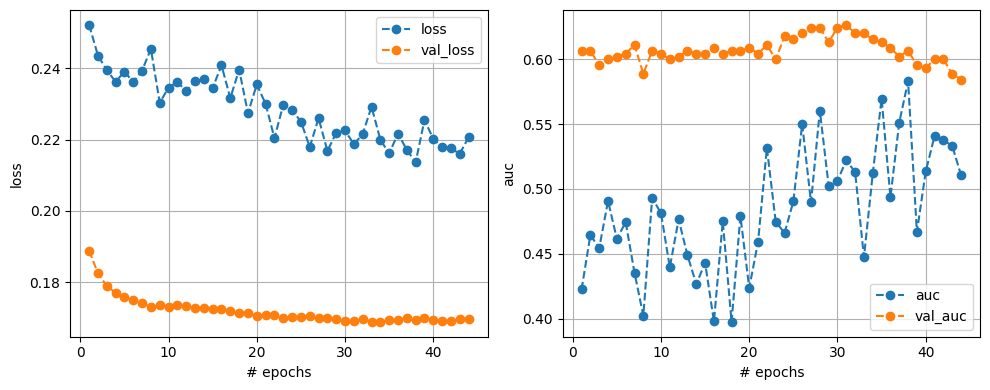

12/12 [==============================] - 3s 184ms/step - loss: 0.2206 - auc: 0.5108 - val_loss: 0.1697 - val_auc: 0.5844
Training time: 150.71998476982117 seconds


In [15]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

start = time.time()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Max Sensitivity at Specificity >= 0.93: 0.00


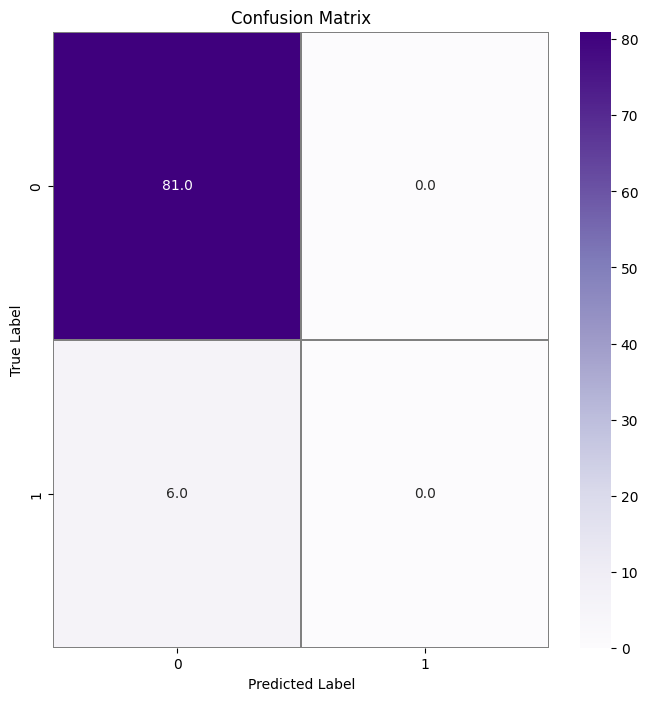

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        81
           1       0.00      0.00      0.00         6

    accuracy                           0.93        87
   macro avg       0.47      0.50      0.48        87
weighted avg       0.87      0.93      0.90        87

                   Model Name  Max Sensitivity at Specificity 0.93   AUC  \
0  ResNet18-TL-no-CW-anterior                                    0  0.53   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV  \
0                      0.0      0.93          0.0          1.0  0.0  0.93   

   PLR  NLR  
0  NaN  1.0  


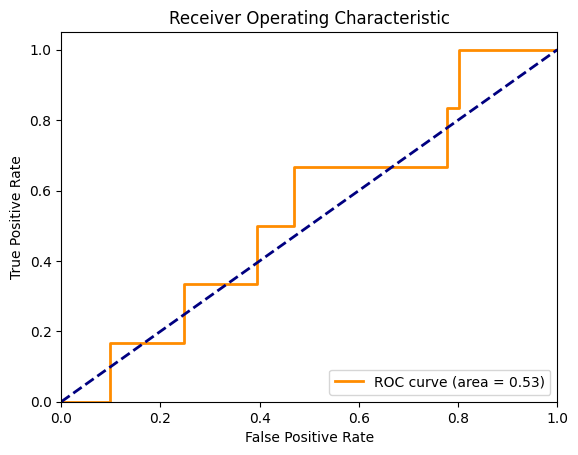

In [16]:
get_model_metrics(test_data=prep_test_data, model=model_resnet18, model_name='ResNet18-TL-no-CW-anterior')

# Hyperparameter tuning of best model (original)

Best model after re-training on different planes: original or anterior plane.

In [31]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/pre-11-mask/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/pre-11-mask/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/pre-11-mask/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 748 files belonging to 2 classes.
Found 159 files belonging to 2 classes.
Found 166 files belonging to 2 classes.


In [32]:
def preprocess_data_resnet18(image, label):
    image = preprocess_input(image)
    return image, label

prep_train_data = train_data.map(preprocess_data_resnet18)
prep_val_data = val_data.map(preprocess_data_resnet18)
prep_test_data = test_data.map(preprocess_data_resnet18)

train_data_augmented = prep_train_data.map(augment_image)

In [33]:
# Custom metric function for optimization
def sensitivity_at_specificity(val_test, model, min_specificity):    
    predicted_probs = []
    true_labels = []
    for images, labels in val_test:
        predictions = model.predict(images, verbose=0)
        predicted_probs.extend(predictions.flatten())
        true_labels.extend([int(label) for label in labels])
        
    # ROC AUC
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)
    
    max_sensitivity = 0
    for i in range(len(fpr)):
        specificity = min_specificity
        if specificity >= min_specificity:
            max_sensitivity = max(max_sensitivity, tpr[i])
    
    return max_sensitivity

In [34]:
import optuna

def build_model(base_model, transfer_learning, trial):
    if transfer_learning == 'Y':
        base_model.trainable = False
    else:
        base_model.trainable = True

    input_layer = Input(shape=(224, 224, 1), name='greyscale_input')
    x = Conv2D(3, (3, 3), padding='same')(input_layer)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)

    n_layers = trial.suggest_int('n_layers', 1, 3)
    for i in range(n_layers):
        x = Dense(trial.suggest_int('units_l{}'.format(i), 50, 200), activation='relu')(x)
        dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
        x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=outputs)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=METRICS)

    return model


def objective(trial):
    base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y', trial=trial)

    rn_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    rn_checkpoint = tf.keras.callbacks.ModelCheckpoint('mb_best_weights.h5', save_best_only=True, save_weights_only=True)

    start = time.time()
    history = model_resnet18.fit(train_data_augmented,
                              epochs=150,
                              validation_data=prep_val_data,
                              callbacks=[rn_callback, rn_checkpoint]
                             )
    end = time.time()
    print('Training time:', end - start, 'seconds')

    #_, auc = model_resnet18.evaluate(prep_val_data, verbose=0)
    #return auc

    sensitivity = sensitivity_at_specificity(prep_val_data, model_resnet18, 0.94)

    
    return sensitivity

In [35]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2023-12-26 10:42:54,128] A new study created in memory with name: no-name-8a3bd9b6-dce5-4dcf-aa9b-e798e69e6f1d


44920640/44920640 [==============================] - 0s 0us/step
Epoch 1/150


/tmp/ipykernel_42/189389192.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/189389192.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


24/24 [==============================] - 15s 230ms/step - loss: 0.8579 - auc: 0.5014 - val_loss: 0.6586 - val_auc: 0.3244
Epoch 2/150
24/24 [==============================] - 4s 126ms/step - loss: 0.8031 - auc: 0.5744 - val_loss: 0.6429 - val_auc: 0.3293
Epoch 3/150
24/24 [==============================] - 4s 127ms/step - loss: 0.7971 - auc: 0.4923 - val_loss: 0.6278 - val_auc: 0.3326
Epoch 4/150
24/24 [==============================] - 4s 133ms/step - loss: 0.7913 - auc: 0.5371 - val_loss: 0.6129 - val_auc: 0.3326
Epoch 5/150
24/24 [==============================] - 4s 127ms/step - loss: 0.7667 - auc: 0.4940 - val_loss: 0.5984 - val_auc: 0.3385
Epoch 6/150
24/24 [==============================] - 4s 131ms/step - loss: 0.7455 - auc: 0.4998 - val_loss: 0.5844 - val_auc: 0.3356
Epoch 7/150
24/24 [==============================] - 4s 125ms/step - loss: 0.6999 - auc: 0.5072 - val_loss: 0.5712 - val_auc: 0.3496
Epoch 8/150
24/24 [==============================] - 4s 128ms/step - loss: 0.728

[I 2023-12-26 10:52:16,787] Trial 0 finished with value: 1.0 and parameters: {'n_layers': 2, 'units_l0': 91, 'dropout_l0': 0.34266613472859886, 'units_l1': 121, 'dropout_l1': 0.3414465657329214, 'learning_rate': 1.567957379061595e-06}. Best is trial 0 with value: 1.0.


Epoch 1/150


/tmp/ipykernel_42/189389192.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/189389192.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


24/24 [==============================] - 8s 161ms/step - loss: 0.3554 - auc: 0.4891 - val_loss: 0.2178 - val_auc: 0.5937
Epoch 2/150
24/24 [==============================] - 4s 118ms/step - loss: 0.2919 - auc: 0.4835 - val_loss: 0.2223 - val_auc: 0.5937
Epoch 3/150
24/24 [==============================] - 4s 117ms/step - loss: 0.2775 - auc: 0.5056 - val_loss: 0.2219 - val_auc: 0.5933
Epoch 4/150
24/24 [==============================] - 4s 126ms/step - loss: 0.2996 - auc: 0.3917 - val_loss: 0.2171 - val_auc: 0.6089
Epoch 5/150
24/24 [==============================] - 4s 125ms/step - loss: 0.2761 - auc: 0.4814 - val_loss: 0.2156 - val_auc: 0.6130
Epoch 6/150
24/24 [==============================] - 4s 117ms/step - loss: 0.2749 - auc: 0.4826 - val_loss: 0.2177 - val_auc: 0.6074
Epoch 7/150
24/24 [==============================] - 4s 125ms/step - loss: 0.2608 - auc: 0.5311 - val_loss: 0.2148 - val_auc: 0.6233
Epoch 8/150
24/24 [==============================] - 4s 126ms/step - loss: 0.2623

[I 2023-12-26 10:54:10,845] Trial 1 finished with value: 1.0 and parameters: {'n_layers': 2, 'units_l0': 125, 'dropout_l0': 0.43588019021365393, 'units_l1': 188, 'dropout_l1': 0.39638429664614894, 'learning_rate': 6.189806217511294e-05}. Best is trial 0 with value: 1.0.


Epoch 1/150


/tmp/ipykernel_42/189389192.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/189389192.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


24/24 [==============================] - 7s 148ms/step - loss: 0.4486 - auc: 0.4514 - val_loss: 0.2771 - val_auc: 0.4644
Epoch 2/150
24/24 [==============================] - 4s 126ms/step - loss: 0.3210 - auc: 0.4919 - val_loss: 0.2310 - val_auc: 0.5074
Epoch 3/150
24/24 [==============================] - 4s 127ms/step - loss: 0.2774 - auc: 0.4948 - val_loss: 0.2230 - val_auc: 0.5215
Epoch 4/150
24/24 [==============================] - 4s 143ms/step - loss: 0.2707 - auc: 0.4958 - val_loss: 0.2223 - val_auc: 0.5411
Epoch 5/150
24/24 [==============================] - 4s 118ms/step - loss: 0.2643 - auc: 0.5023 - val_loss: 0.2228 - val_auc: 0.5415
Epoch 6/150
24/24 [==============================] - 4s 117ms/step - loss: 0.2532 - auc: 0.5176 - val_loss: 0.2232 - val_auc: 0.5396
Epoch 7/150
24/24 [==============================] - 4s 117ms/step - loss: 0.2669 - auc: 0.4851 - val_loss: 0.2238 - val_auc: 0.5456
Epoch 8/150
24/24 [==============================] - 4s 116ms/step - loss: 0.2532

[I 2023-12-26 10:57:53,816] Trial 2 finished with value: 1.0 and parameters: {'n_layers': 2, 'units_l0': 191, 'dropout_l0': 0.2882413860208818, 'units_l1': 159, 'dropout_l1': 0.3713189866243548, 'learning_rate': 2.5547005488103517e-05}. Best is trial 0 with value: 1.0.


Epoch 1/150


/tmp/ipykernel_42/189389192.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/189389192.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


24/24 [==============================] - 7s 144ms/step - loss: 0.6369 - auc: 0.4988 - val_loss: 0.5605 - val_auc: 0.6348
Epoch 2/150
24/24 [==============================] - 4s 124ms/step - loss: 0.6096 - auc: 0.4648 - val_loss: 0.5117 - val_auc: 0.6285
Epoch 3/150
24/24 [==============================] - 4s 132ms/step - loss: 0.5440 - auc: 0.5160 - val_loss: 0.4705 - val_auc: 0.6274
Epoch 4/150
24/24 [==============================] - 4s 126ms/step - loss: 0.5109 - auc: 0.4870 - val_loss: 0.4348 - val_auc: 0.6278
Epoch 5/150
24/24 [==============================] - 4s 125ms/step - loss: 0.4713 - auc: 0.5592 - val_loss: 0.4048 - val_auc: 0.6256
Epoch 6/150
24/24 [==============================] - 4s 124ms/step - loss: 0.4402 - auc: 0.5137 - val_loss: 0.3787 - val_auc: 0.6230
Epoch 7/150
24/24 [==============================] - 4s 128ms/step - loss: 0.4123 - auc: 0.5445 - val_loss: 0.3563 - val_auc: 0.6159
Epoch 8/150
24/24 [==============================] - 4s 129ms/step - loss: 0.3877

[I 2023-12-26 11:01:55,855] Trial 3 finished with value: 1.0 and parameters: {'n_layers': 1, 'units_l0': 86, 'dropout_l0': 0.3545973331005987, 'learning_rate': 4.847592810359706e-06}. Best is trial 0 with value: 1.0.


Epoch 1/150


/tmp/ipykernel_42/189389192.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/189389192.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


24/24 [==============================] - 7s 144ms/step - loss: 0.8203 - auc: 0.5172 - val_loss: 0.5680 - val_auc: 0.4296
Epoch 2/150
24/24 [==============================] - 4s 127ms/step - loss: 0.7449 - auc: 0.5106 - val_loss: 0.5231 - val_auc: 0.4348
Epoch 3/150
24/24 [==============================] - 4s 126ms/step - loss: 0.7012 - auc: 0.5435 - val_loss: 0.4834 - val_auc: 0.4407
Epoch 4/150
24/24 [==============================] - 4s 127ms/step - loss: 0.6563 - auc: 0.5330 - val_loss: 0.4489 - val_auc: 0.4470
Epoch 5/150
24/24 [==============================] - 4s 126ms/step - loss: 0.6745 - auc: 0.4703 - val_loss: 0.4175 - val_auc: 0.4530
Epoch 6/150
24/24 [==============================] - 4s 132ms/step - loss: 0.5627 - auc: 0.5216 - val_loss: 0.3900 - val_auc: 0.4611
Epoch 7/150
24/24 [==============================] - 4s 129ms/step - loss: 0.6043 - auc: 0.5456 - val_loss: 0.3653 - val_auc: 0.4615
Epoch 8/150
24/24 [==============================] - 4s 128ms/step - loss: 0.5500

[I 2023-12-26 11:04:51,590] Trial 4 finished with value: 1.0 and parameters: {'n_layers': 1, 'units_l0': 81, 'dropout_l0': 0.41448767797371405, 'learning_rate': 3.1363452300342374e-06}. Best is trial 0 with value: 1.0.


Epoch 1/150


/tmp/ipykernel_42/189389192.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/189389192.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


24/24 [==============================] - 8s 148ms/step - loss: 0.5259 - auc: 0.4794 - val_loss: 0.3409 - val_auc: 0.4819
Epoch 2/150
24/24 [==============================] - 4s 127ms/step - loss: 0.3518 - auc: 0.5118 - val_loss: 0.2471 - val_auc: 0.4641
Epoch 3/150
24/24 [==============================] - 4s 127ms/step - loss: 0.2800 - auc: 0.5586 - val_loss: 0.2274 - val_auc: 0.4641
Epoch 4/150
24/24 [==============================] - 4s 126ms/step - loss: 0.2741 - auc: 0.4884 - val_loss: 0.2247 - val_auc: 0.4819
Epoch 5/150
24/24 [==============================] - 4s 126ms/step - loss: 0.2729 - auc: 0.4842 - val_loss: 0.2243 - val_auc: 0.4696
Epoch 6/150
24/24 [==============================] - 4s 126ms/step - loss: 0.2752 - auc: 0.4432 - val_loss: 0.2238 - val_auc: 0.4841
Epoch 7/150
24/24 [==============================] - 4s 126ms/step - loss: 0.2652 - auc: 0.4751 - val_loss: 0.2226 - val_auc: 0.4907
Epoch 8/150
24/24 [==============================] - 4s 127ms/step - loss: 0.2754

[I 2023-12-26 11:11:14,889] Trial 5 finished with value: 1.0 and parameters: {'n_layers': 3, 'units_l0': 185, 'dropout_l0': 0.26180243064515674, 'units_l1': 113, 'dropout_l1': 0.3325645067249917, 'units_l2': 88, 'dropout_l2': 0.23234007527425607, 'learning_rate': 3.6183522214485565e-05}. Best is trial 0 with value: 1.0.


Epoch 1/150


/tmp/ipykernel_42/189389192.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/189389192.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


24/24 [==============================] - 8s 146ms/step - loss: 0.7895 - auc: 0.5552 - val_loss: 0.8826 - val_auc: 0.5241
Epoch 2/150
24/24 [==============================] - 4s 126ms/step - loss: 0.7729 - auc: 0.4886 - val_loss: 0.8690 - val_auc: 0.5200
Epoch 3/150
24/24 [==============================] - 4s 132ms/step - loss: 0.7938 - auc: 0.4437 - val_loss: 0.8555 - val_auc: 0.5196
Epoch 4/150
24/24 [==============================] - 4s 126ms/step - loss: 0.7666 - auc: 0.4655 - val_loss: 0.8425 - val_auc: 0.5256
Epoch 5/150
24/24 [==============================] - 4s 129ms/step - loss: 0.7572 - auc: 0.4624 - val_loss: 0.8296 - val_auc: 0.5256
Epoch 6/150
24/24 [==============================] - 4s 125ms/step - loss: 0.7120 - auc: 0.5616 - val_loss: 0.8173 - val_auc: 0.5274
Epoch 7/150
24/24 [==============================] - 4s 126ms/step - loss: 0.7133 - auc: 0.5123 - val_loss: 0.8050 - val_auc: 0.5267
Epoch 8/150
24/24 [==============================] - 4s 139ms/step - loss: 0.7187

[I 2023-12-26 11:21:01,098] Trial 6 finished with value: 1.0 and parameters: {'n_layers': 3, 'units_l0': 72, 'dropout_l0': 0.3394068911209742, 'units_l1': 151, 'dropout_l1': 0.46123121250058113, 'units_l2': 157, 'dropout_l2': 0.26729532568570114, 'learning_rate': 1.4413997325424286e-06}. Best is trial 0 with value: 1.0.


Epoch 1/150


/tmp/ipykernel_42/189389192.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/189389192.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


24/24 [==============================] - 7s 145ms/step - loss: 0.7453 - auc: 0.5389 - val_loss: 0.3621 - val_auc: 0.4993
Epoch 2/150
24/24 [==============================] - 4s 125ms/step - loss: 0.4273 - auc: 0.6123 - val_loss: 0.2490 - val_auc: 0.5111
Epoch 3/150
24/24 [==============================] - 4s 134ms/step - loss: 0.3349 - auc: 0.5609 - val_loss: 0.2263 - val_auc: 0.5211
Epoch 4/150
24/24 [==============================] - 4s 125ms/step - loss: 0.3069 - auc: 0.5248 - val_loss: 0.2217 - val_auc: 0.5270
Epoch 5/150
24/24 [==============================] - 4s 118ms/step - loss: 0.2896 - auc: 0.5393 - val_loss: 0.2226 - val_auc: 0.5293
Epoch 6/150
24/24 [==============================] - 4s 118ms/step - loss: 0.2989 - auc: 0.4970 - val_loss: 0.2238 - val_auc: 0.5296
Epoch 7/150
24/24 [==============================] - 4s 117ms/step - loss: 0.3101 - auc: 0.4758 - val_loss: 0.2247 - val_auc: 0.5093
Epoch 8/150
24/24 [==============================] - 4s 116ms/step - loss: 0.3058

[I 2023-12-26 11:23:20,765] Trial 7 finished with value: 1.0 and parameters: {'n_layers': 2, 'units_l0': 114, 'dropout_l0': 0.384117708671039, 'units_l1': 65, 'dropout_l1': 0.4846789558324404, 'learning_rate': 4.707489157211187e-05}. Best is trial 0 with value: 1.0.


Epoch 1/150


/tmp/ipykernel_42/189389192.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/189389192.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


24/24 [==============================] - 7s 144ms/step - loss: 0.8451 - auc: 0.4772 - val_loss: 0.3708 - val_auc: 0.5900
Epoch 2/150
24/24 [==============================] - 4s 126ms/step - loss: 0.3871 - auc: 0.4408 - val_loss: 0.2371 - val_auc: 0.5733
Epoch 3/150
24/24 [==============================] - 4s 127ms/step - loss: 0.2689 - auc: 0.5610 - val_loss: 0.2186 - val_auc: 0.5807
Epoch 4/150
24/24 [==============================] - 4s 127ms/step - loss: 0.2626 - auc: 0.4707 - val_loss: 0.2176 - val_auc: 0.5778
Epoch 5/150
24/24 [==============================] - 4s 117ms/step - loss: 0.2510 - auc: 0.5152 - val_loss: 0.2182 - val_auc: 0.5933
Epoch 6/150
24/24 [==============================] - 4s 117ms/step - loss: 0.2585 - auc: 0.4618 - val_loss: 0.2181 - val_auc: 0.5822
Epoch 7/150
24/24 [==============================] - 4s 116ms/step - loss: 0.2442 - auc: 0.5418 - val_loss: 0.2192 - val_auc: 0.5726
Epoch 8/150
24/24 [==============================] - 4s 132ms/step - loss: 0.2528

[I 2023-12-26 11:24:18,185] Trial 8 finished with value: 1.0 and parameters: {'n_layers': 2, 'units_l0': 194, 'dropout_l0': 0.2989436445512285, 'units_l1': 120, 'dropout_l1': 0.29966993220463367, 'learning_rate': 5.01449282185108e-05}. Best is trial 0 with value: 1.0.


Epoch 1/150


/tmp/ipykernel_42/189389192.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/189389192.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


24/24 [==============================] - 7s 147ms/step - loss: 0.7050 - auc: 0.5533 - val_loss: 0.2917 - val_auc: 0.6381
Epoch 2/150
24/24 [==============================] - 4s 127ms/step - loss: 0.3155 - auc: 0.5076 - val_loss: 0.2165 - val_auc: 0.6289
Epoch 3/150
24/24 [==============================] - 4s 126ms/step - loss: 0.2693 - auc: 0.4737 - val_loss: 0.2142 - val_auc: 0.6296
Epoch 4/150
24/24 [==============================] - 4s 119ms/step - loss: 0.2569 - auc: 0.4800 - val_loss: 0.2144 - val_auc: 0.6304
Epoch 5/150
24/24 [==============================] - 4s 119ms/step - loss: 0.2511 - auc: 0.5387 - val_loss: 0.2146 - val_auc: 0.6285
Epoch 6/150
24/24 [==============================] - 4s 126ms/step - loss: 0.2525 - auc: 0.5184 - val_loss: 0.2141 - val_auc: 0.6289
Epoch 7/150
24/24 [==============================] - 4s 117ms/step - loss: 0.2635 - auc: 0.4365 - val_loss: 0.2141 - val_auc: 0.6211
Epoch 8/150
24/24 [==============================] - 4s 116ms/step - loss: 0.2425

[I 2023-12-26 11:25:22,474] Trial 9 finished with value: 1.0 and parameters: {'n_layers': 1, 'units_l0': 135, 'dropout_l0': 0.42774392794762994, 'learning_rate': 6.125895333332064e-05}. Best is trial 0 with value: 1.0.


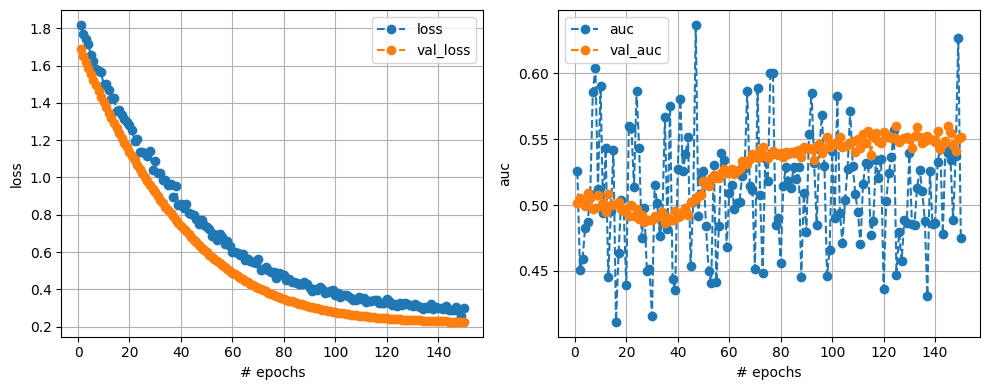

24/24 [==============================] - 4s 151ms/step - loss: 0.3003 - auc: 0.4749 - val_loss: 0.2259 - val_auc: 0.5519


In [36]:
# Extract the best hyperparameters
best_trial = study.best_trial.params

# Base model
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Rebuild the model with the best hyperparameters
model = build_model(base_model=base_resnet18, 
                    transfer_learning='Y', 
                    trial=optuna.trial.FixedTrial(best_trial))

# Callbacks
rn_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn_checkpoint = ModelCheckpoint('mb_best_weights.h5', save_best_only=True, save_weights_only=True)
rn_plot_callback = PlotLearning()

# Retrain the model
history = model.fit(train_data_augmented,
                    epochs=150,
                    validation_data=prep_val_data,
                    callbacks=[rn_callback, rn_checkpoint, rn_plot_callback],
                   )

Max Sensitivity at Specificity >= 0.93: 0.00


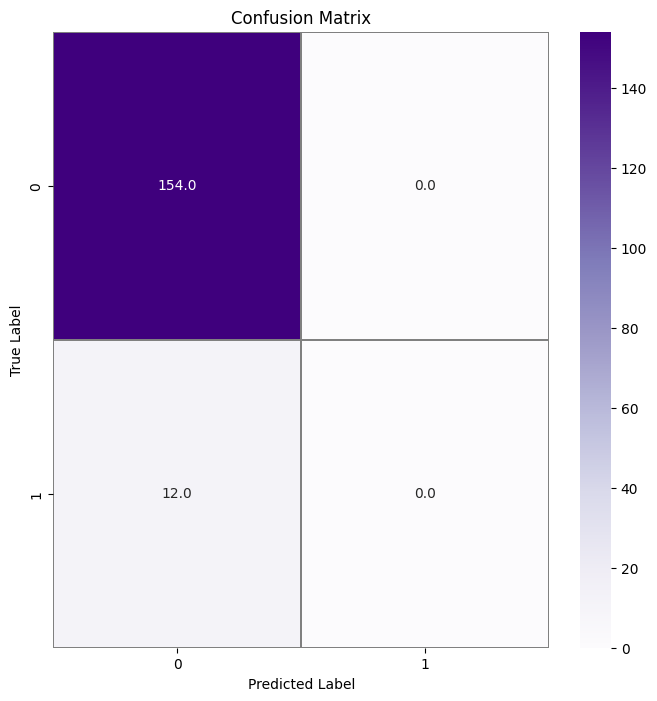

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       154
           1       0.00      0.00      0.00        12

    accuracy                           0.93       166
   macro avg       0.46      0.50      0.48       166
weighted avg       0.86      0.93      0.89       166

                Model Name  Max Sensitivity at Specificity 0.93  AUC  \
0  ResNet18-TL-no-CW-tuned                                    0  0.4   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV  \
0                      0.0      0.93          0.0          1.0  0.0  0.93   

   PLR  NLR  
0  NaN  1.0  


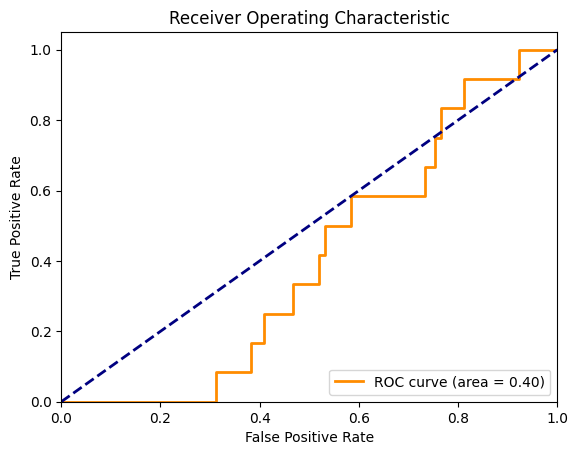

In [37]:
get_model_metrics(test_data=prep_test_data, model=model, model_name='ResNet18-TL-no-CW-tuned')